In [1]:
#2/4 06:49
import numpy as np  
from numpy  import array
import pandas as pd
from keras.models import Sequential  
from keras.optimizers import RMSprop , Adam
from keras.layers import GaussianNoise, Dense , Conv2D , Activation , Dropout , Flatten , BatchNormalization , Reshape , UpSampling2D ,Conv2DTranspose,MaxPooling2D
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
import h5py
import os
from os import listdir
from os.path import isfile, isdir, join
from keras import backend as K
from PIL import Image
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'




Using TensorFlow backend.


In [2]:
batch_size = 32;

In [3]:
mypath = "fruit"
files = listdir(mypath)
label = 1
imglist = []
labellist= []
for f in files:
    fullpath = join(mypath, f)
    print("目錄：", fullpath)
    files2 = listdir(fullpath)
    for f2 in files2:
        fullpath2 = join(fullpath, f2)
        img=np.array(Image.open(fullpath2))
        o = np.ones(img.shape)
        img = img - (o * 127.5) 
        img = img / 127.5
        img=img
        imglist.append(img)
        labellist.append(label)
    label = label + 1



目錄： fruit\Apple
目錄： fruit\Banana
目錄： fruit\Carambula
目錄： fruit\Cherry
目錄： fruit\Grape Pink
目錄： fruit\Grape White
目錄： fruit\Guava
目錄： fruit\Kiwi
目錄： fruit\Lemon
目錄： fruit\Litchi
目錄： fruit\Mandarine
目錄： fruit\Orange
目錄： fruit\Passion Fruit
目錄： fruit\Peach
目錄： fruit\Pear
目錄： fruit\Pineapple
目錄： fruit\Pitahaya Red
目錄： fruit\Plum
目錄： fruit\Pomegranate
目錄： fruit\Strawberry


In [4]:
combined = list(zip(imglist, labellist))
random.shuffle(combined)
imglist[:], labellist[:] = zip(*combined)
#print(imglist[1888])
#print(labellist[1888])

In [5]:
RealY = np_utils.to_categorical(labellist,num_classes=21)
RealY = RealY*0.85
RealY

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.85],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [6]:
#鑑定器 D
# In: 100 x 100 x 1, depth = 3
modelD = Sequential()

modelD.add(Conv2D(filters=16, strides=2 , kernel_size=(5, 5), padding='same', input_shape=(100, 100, 3)))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=32, strides=2 , kernel_size=(5, 5), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=64, strides=2 , kernel_size=(3, 3), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=128, strides=2 , kernel_size=(3, 3), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))
           
#modelD.add(Dropout(0.2))
modelD.add(Flatten())
modelD.add(Dense(1))
modelD.add(Activation('sigmoid'))
modelD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
__________

In [7]:
#生成器 G
# In: 512
modelG = Sequential()
modelG.add(Dense(25*25*128, input_dim=100))
modelG.add(Activation('relu'))
#modelG.add(Dropout(0.3))
modelG.add(Reshape((25, 25, 128)))
modelG.add(Conv2DTranspose(128, kernel_size = (5,5), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))

modelG.add(Conv2DTranspose(64, kernel_size = (5,5), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))


modelG.add(Conv2DTranspose(3, kernel_size = (5,5), strides=(1, 1), padding='same'))
#modelG.add(BatchNormalization())
modelG.add(Activation('tanh'))
modelG.add(Reshape((100, 100, 3)))
modelG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 80000)             8080000   
_________________________________________________________________
activation_2 (Activation)    (None, 80000)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 50, 50, 128)       409728    
_________________________________________________________________
batch_normalization_5 (Batch (None, 50, 50, 128)       512       
_________________________________________________________________
activation_3 (Activation)    (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 100, 100, 64)      204864    
__________

In [8]:
#D
optimizerD = Adam(0.0002, 0.5)
modelTD = Sequential()
modelTD.add(modelD)
modelTD.compile(loss='binary_crossentropy', optimizer=optimizerD,metrics=['accuracy'])
#A1
optimizerA = Adam(0.00015, 0.5)
modelTA = Sequential()
modelTA.add(modelG)
modelTA.add(modelTD)
modelTD.trainable = False
modelTA.compile(loss='binary_crossentropy', optimizer=optimizerA,metrics=['accuracy'])

In [9]:
a_loss_record = []
d_loss_record = []
dF_loss_record = []
dR_loss_record = []

In [17]:
def TrainG():
    #Fake_Lable = np.random.randint(0, 10, batch_size)
    #Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=10)
    noise = np.random.uniform(-0.8, 0.8, size=[batch_size, 100]) 
    #NT = np.hstack((Fake_Lable,noise))
    YA = np.ones([batch_size, 1])
    YA = YA  * 0.85
    a_loss = modelTA.train_on_batch(noise,YA)
    a_loss_record.append(a_loss[0])
    print ("A1")
    print (a_loss)
    return a_loss

In [11]:
imgarray = np.asarray(imglist)
imgarray.shape

(3109, 100, 100, 3)

In [12]:
def TrainD():
    Rnd = np.random.randint(0,imgarray.shape[0],size = int(batch_size/2))
    RealX = imgarray[Rnd,:,:,:]     
    YA = np.ones([int(batch_size/2), 1])
    YA = YA  * 0.85
    
    YZ = np.zeros([int(batch_size/2), 1])
    noise = np.random.uniform(-0.8, 0.8, size=[int(batch_size/2), 100])                                   
    FakeX = modelG.predict(noise)
                                             
    gauss = np.random.normal(0,0.25,(int(batch_size/2),100,100,3))
    RealGX = RealX + gauss
    gauss = np.random.normal(0,0.25,(int(batch_size/2),100,100,3))
    FakeGX = FakeX + gauss 

    d_lossR = modelTD.train_on_batch(RealGX, YA)
    print ("D1R")
    print (d_lossR)
    d_lossF = modelTD.train_on_batch(FakeGX, YZ)
    print ("D1F")
    print (d_lossF)
    #
    d_loss =  (d_lossR[0] +  d_lossF[0]) / 2
    d_loss_record.append(d_loss)
  #  print ("D")
  #  print (d_loss)
    dR_loss_record.append(d_lossR[0])
    dF_loss_record.append(d_lossF[0])
    return d_loss
    

In [13]:
def Show():
    noise = np.random.uniform(-1, 1, size=[batch_size, 100])                                          
    FakeX = modelG.predict(noise)
    img = FakeX[0]
    img = img.reshape(100,100,3)
    img = img * 0.5 + 0.5
    plt.imshow(img) 
    plt.show()

In [14]:
def ShowPlt():
    plt.plot(d_loss_record,label="d_loss")
    plt.plot(a_loss_record,label="a_loss")
    plt.plot(dR_loss_record,label="dR_loss")
    plt.plot(dF_loss_record,label="dF_loss")
    plt.legend()
    plt.show()


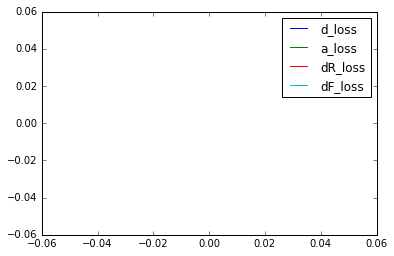

In [15]:
ShowPlt()

4803


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D1R
[1.1640174, 0.0]
D1F
[0.16711757, 1.0]
A1
[0.46869898, 0.0]


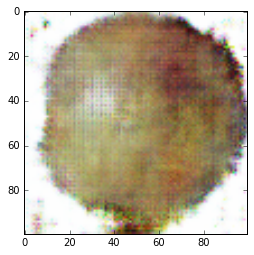

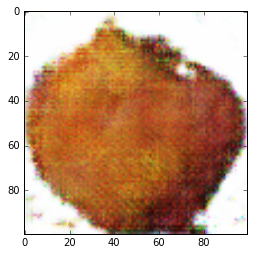

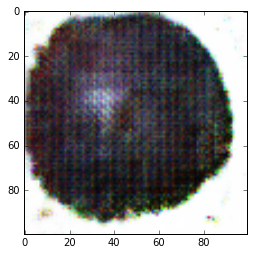

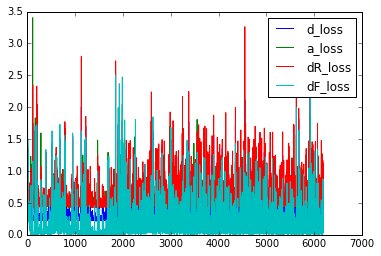

4804
D1R
[0.50936723, 0.0]
D1F
[0.38609174, 0.8125]
A1
[0.46535456, 0.0]
4805
D1R
[0.46710393, 0.0]
D1F
[0.06964533, 1.0]
A1
[0.49824172, 0.0]
4806
D1R
[0.4490712, 0.0]
D1F
[0.021907782, 1.0]
A1
[0.44302577, 0.0]
4807
D1R
[0.48827821, 0.0]
D1F
[0.022537047, 1.0]
A1
[0.47646016, 0.0]
4808
D1R
[0.46919602, 0.0]
D1F
[0.052328609, 1.0]
A1
[0.47501957, 0.0]
4809
D1R
[0.74477214, 0.0]
D1F
[0.11527526, 1.0]
A1
[0.47283298, 0.0]
4810
D1R
[0.48164529, 0.0]
D1F
[0.023970492, 1.0]
A1
[0.51452923, 0.0]
4811
D1R
[0.51515496, 0.0]
D1F
[0.42458057, 0.8125]
A1
[0.44707388, 0.0]
4812
D1R
[0.46080476, 0.0]
D1F
[0.061363533, 1.0]
A1
[0.48287952, 0.0]
4813
D1R
[0.67177451, 0.0]
D1F
[0.072215162, 1.0]
A1
[0.469024, 0.0]


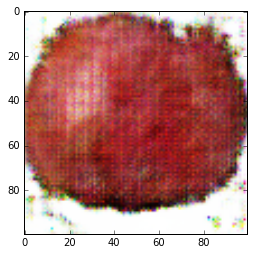

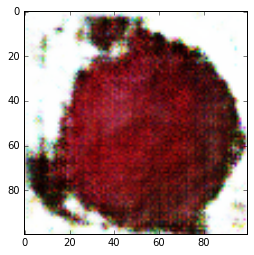

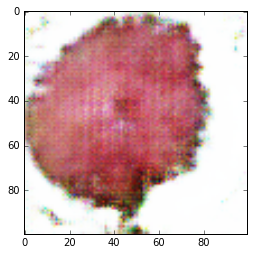

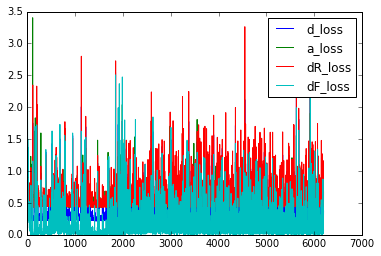

4814
D1R
[1.2414384, 0.0]
D1F
[0.43764436, 0.875]
A1
[0.4836545, 0.0]
4815
D1R
[0.47896242, 0.0]
D1F
[0.54308414, 0.75]
A1
[0.46443057, 0.0]
4816
D1R
[0.48030823, 0.0]
D1F
[0.07132861, 1.0]
A1
[0.87709463, 0.0]
4817
D1R
[0.93176544, 0.0]
D1F
[0.18329084, 1.0]
A1
[0.45207083, 0.0]
4818
D1R
[0.47082078, 0.0]
D1F
[0.06619259, 1.0]
A1
[0.47883481, 0.0]
4819
D1R
[0.44902787, 0.0]
D1F
[0.028211797, 1.0]
A1
[0.49986464, 0.0]
4820
D1R
[0.59286159, 0.0]
D1F
[0.084235415, 1.0]
A1
[0.45900616, 0.0]
4821
D1R
[0.5651471, 0.0]
D1F
[0.030886082, 1.0]
A1
[0.48607391, 0.0]
4822
D1R
[0.49896973, 0.0]
D1F
[0.13274157, 1.0]
A1
[0.51811963, 0.0]
4823
D1R
[0.44862556, 0.0]
D1F
[0.023903882, 1.0]
A1
[0.48892823, 0.0]


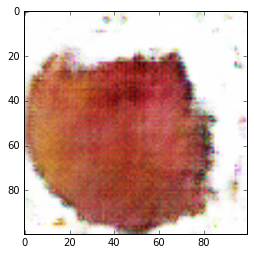

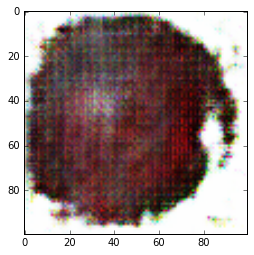

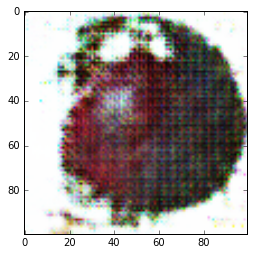

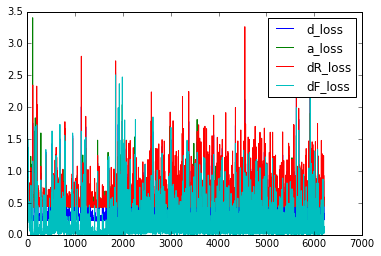

4824
D1R
[0.51361585, 0.0]
D1F
[0.015840743, 1.0]
A1
[0.45364779, 0.0]
4825
D1R
[0.67519599, 0.0]
D1F
[0.16218823, 1.0]
A1
[0.46323168, 0.0]
4826
D1R
[0.45238614, 0.0]
D1F
[0.059569184, 1.0]
A1
[0.46480271, 0.0]
4827
D1R
[0.44583017, 0.0]
D1F
[0.038167067, 1.0]
A1
[0.49244928, 0.0]
4828
D1R
[0.49814862, 0.0]
D1F
[0.11031723, 1.0]
A1
[0.46362907, 0.0]
4829
D1R
[0.53082871, 0.0]
D1F
[0.093980186, 1.0]
A1
[0.47084737, 0.0]
4830
D1R
[0.53221703, 0.0]
D1F
[0.012363302, 1.0]
A1
[0.45058244, 0.0]
4831
D1R
[0.45995507, 0.0]
D1F
[0.0069595091, 1.0]
A1
[0.44291022, 0.0]
4832
D1R
[0.47644487, 0.0]
D1F
[0.0050073536, 1.0]
A1
[0.45667726, 0.0]
4833
D1R
[0.46791184, 0.0]
D1F
[0.019220464, 1.0]
A1
[0.46294266, 0.0]


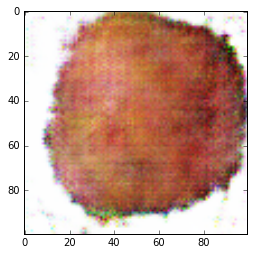

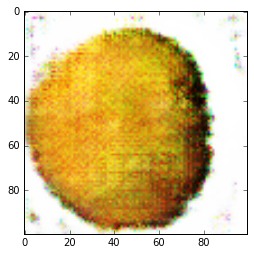

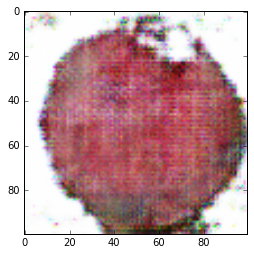

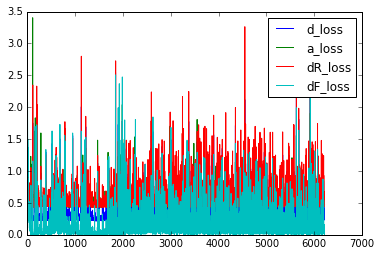

4834
D1R
[0.89660817, 0.0]
D1F
[0.49872139, 0.75]
A1
[0.5011543, 0.0]
4835
D1R
[0.52349168, 0.0]
D1F
[0.10764649, 1.0]
A1
[0.44553617, 0.0]
4836
D1R
[0.55270827, 0.0]
D1F
[0.047629043, 1.0]
A1
[0.45863396, 0.0]
4837
D1R
[0.4575457, 0.0]
D1F
[0.011571122, 1.0]
A1
[0.45693678, 0.0]
4838
D1R
[0.49480051, 0.0]
D1F
[0.034898326, 1.0]
A1
[0.45542863, 0.0]
4839
D1R
[0.4888941, 0.0]
D1F
[0.0071655563, 1.0]
A1
[0.4634175, 0.0]
4840
D1R
[0.61597729, 0.0]
D1F
[0.16828972, 1.0]
A1
[0.48730975, 0.0]
4841
D1R
[0.54886723, 0.0]
D1F
[0.025691397, 1.0]
A1
[0.45456177, 0.0]
4842
D1R
[0.51683849, 0.0]
D1F
[0.028270682, 1.0]
A1
[0.44994834, 0.0]
4843
D1R
[0.52830231, 0.0]
D1F
[0.088449597, 1.0]
A1
[0.45700836, 0.0]


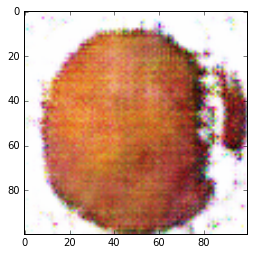

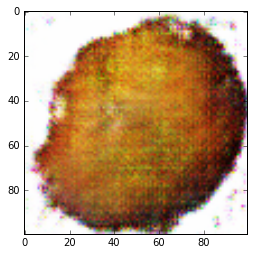

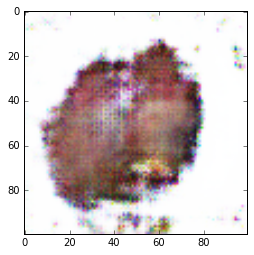

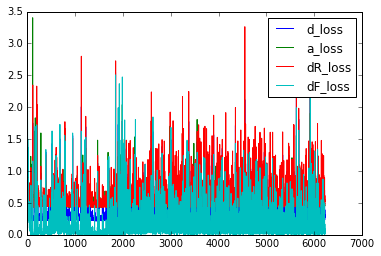

4844
D1R
[0.50543606, 0.0]
D1F
[0.018931754, 1.0]
A1
[0.46046123, 0.0]
4845
D1R
[0.44733614, 0.0]
D1F
[0.016720934, 1.0]
A1
[0.47952071, 0.0]
4846
D1R
[0.49118879, 0.0]
D1F
[0.010717229, 1.0]
A1
[0.45499933, 0.0]
4847
D1R
[0.49652284, 0.0]
D1F
[0.020005506, 1.0]
A1
[0.46588939, 0.0]
4848
D1R
[0.45461029, 0.0]
D1F
[0.029474828, 1.0]
A1
[0.45756623, 0.0]
4849
D1R
[0.64620471, 0.0]
D1F
[0.10255834, 1.0]
A1
[0.52996618, 0.0]
4850
D1R
[0.44796917, 0.0]
D1F
[0.075639538, 1.0]
A1
[0.44465268, 0.0]
4851
D1R
[0.43699783, 0.0]
D1F
[0.027478868, 1.0]
A1
[0.4451392, 0.0]
4852
D1R
[0.44072011, 0.0]
D1F
[0.0067218207, 1.0]
A1
[0.44515762, 0.0]
4853
D1R
[0.50414002, 0.0]
D1F
[0.057913445, 1.0]
A1
[0.46450916, 0.0]


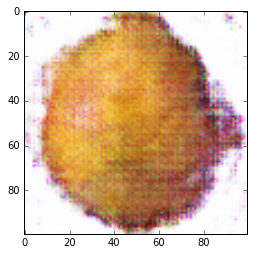

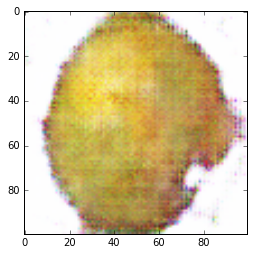

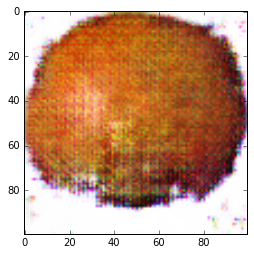

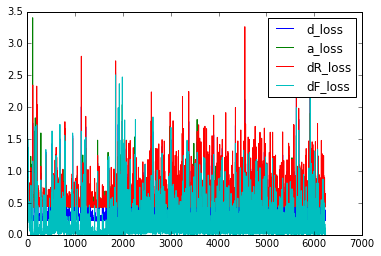

4854
D1R
[0.45351189, 0.0]
D1F
[0.010033181, 1.0]
A1
[0.45509633, 0.0]
4855
D1R
[0.46672237, 0.0]
D1F
[0.016311657, 1.0]
A1
[0.44688189, 0.0]
4856
D1R
[0.47031984, 0.0]
D1F
[0.0067140209, 1.0]
A1
[0.45028815, 0.0]
4857
D1R
[0.43809265, 0.0]
D1F
[0.0056390669, 1.0]
A1
[0.48207495, 0.0]
4858
D1R
[0.43265998, 0.0]
D1F
[0.011247024, 1.0]
A1
[0.45066643, 0.0]
4859
D1R
[0.45293394, 0.0]
D1F
[0.031670295, 1.0]
A1
[0.46094647, 0.0]
4860
D1R
[0.44594705, 0.0]
D1F
[0.016846742, 1.0]
A1
[0.44864875, 0.0]
4861
D1R
[0.48515174, 0.0]
D1F
[0.16794473, 1.0]
A1
[0.44708136, 0.0]
4862
D1R
[0.82060003, 0.0]
D1F
[0.43248343, 0.8125]
A1
[0.44995862, 0.0]
4863
D1R
[0.47779596, 0.0]
D1F
[0.074008793, 1.0]
A1
[0.49741638, 0.0]


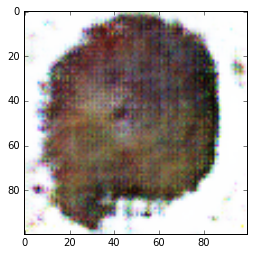

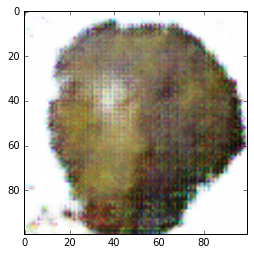

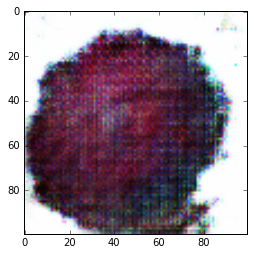

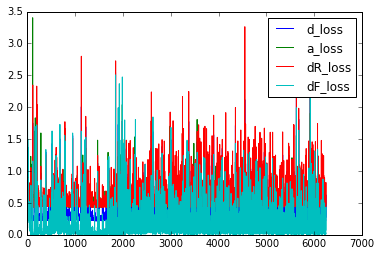

4864
D1R
[0.45727903, 0.0]
D1F
[0.0070041437, 1.0]
A1
[0.62556487, 0.0]
4865
D1R
[0.66639125, 0.0]
D1F
[0.023144498, 1.0]
A1
[0.45744196, 0.0]
4866
D1R
[0.44313377, 0.0]
D1F
[0.05802254, 1.0]
A1
[0.44220102, 0.0]
4867
D1R
[0.48884934, 0.0]
D1F
[0.020893946, 1.0]
A1
[0.45863271, 0.0]
4868
D1R
[0.53381908, 0.0]
D1F
[0.053118359, 1.0]
A1
[0.45128992, 0.0]
4869
D1R
[0.45103246, 0.0]
D1F
[0.057460122, 1.0]
A1
[0.44404078, 0.0]
4870
D1R
[0.45112169, 0.0]
D1F
[0.016465273, 1.0]
A1
[0.45330119, 0.0]
4871
D1R
[0.4839828, 0.0]
D1F
[0.0071203085, 1.0]
A1
[0.44741729, 0.0]
4872
D1R
[0.46389127, 0.0]
D1F
[0.0048754783, 1.0]
A1
[0.44929636, 0.0]
4873
D1R
[0.44569933, 0.0]
D1F
[0.064144887, 1.0]
A1
[0.44485235, 0.0]


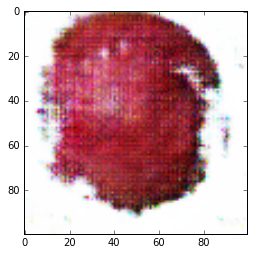

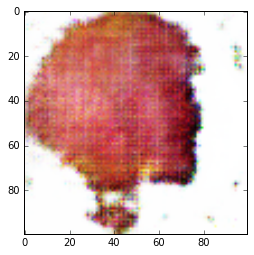

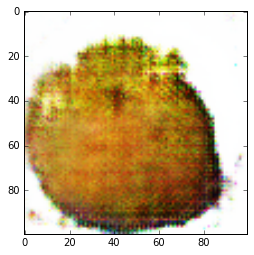

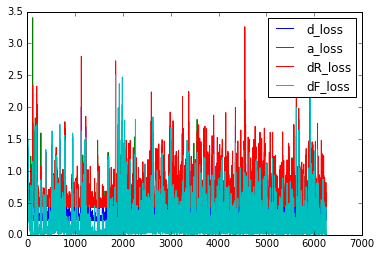

4874
D1R
[0.44829267, 0.0]
D1F
[0.01675212, 1.0]
A1
[0.44964454, 0.0]
4875
D1R
[0.428518, 0.0]
D1F
[0.040517271, 1.0]
A1
[0.45720947, 0.0]
4876
D1R
[0.45395803, 0.0]
D1F
[0.0084129032, 1.0]
A1
[0.45495397, 0.0]
4877
D1R
[0.72985303, 0.0]
D1F
[0.25941581, 0.9375]
A1
[0.4915764, 0.0]
4878
D1R
[0.89607072, 0.0]
D1F
[1.3012176, 0.125]
A1
[0.47521061, 0.0]
4879
D1R
[0.45310125, 0.0]
D1F
[0.049727757, 1.0]
A1
[0.85355294, 0.0]
4880
D1R
[1.0785916, 0.0]
D1F
[0.32305244, 0.875]
A1
[0.48008263, 0.0]
4881
D1R
[0.44715115, 0.0]
D1F
[0.076214179, 1.0]
A1
[0.47335169, 0.0]
4882
D1R
[0.48780072, 0.0]
D1F
[0.20487052, 1.0]
A1
[0.53804815, 0.0]
4883
D1R
[0.68763757, 0.0]
D1F
[0.41608727, 0.875]
A1
[0.47967291, 0.0]


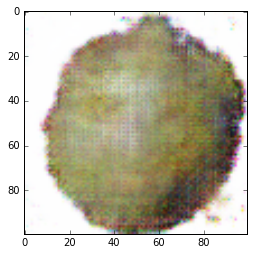

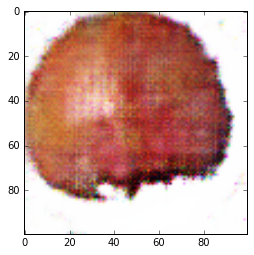

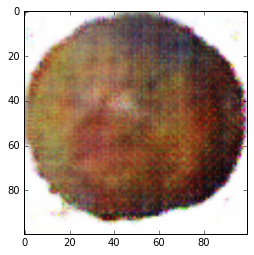

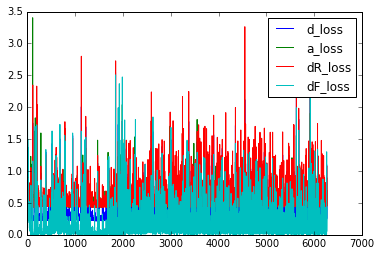

4884
D1R
[0.55880451, 0.0]


In [ ]:
for a in range(10000):
    print (a+4803)
    TrainD()
    TrainG()
    if(a % 10 == 0):
        Show()
        Show()
        Show()
        ShowPlt()

In [14]:
modelTD.load_weights('modelTD5_weights.h5')
modelTA.load_weights('modelTA5_weights.h5')

In [17]:
modelTD.save('modelDFruit.h5') 
modelTA.save('modelTFruit.h5') 
modelTD.save_weights('modelDFruit_weights.h5')
modelTA.save_weights('modelAFruit_weights.h5')


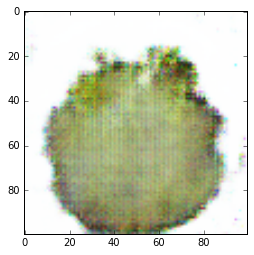

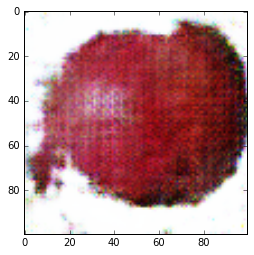

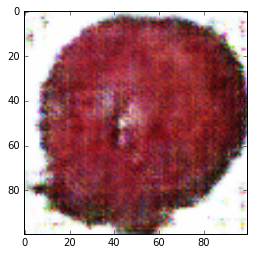

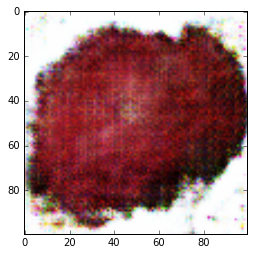

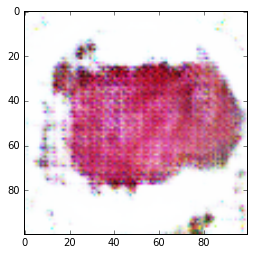

In [32]:
Show()
Show()
Show()
Show()
Show()